# DenseNet201 for Sign language Recognition

steps of notebook:

1. Here we will attempt to preprocess the data however we need to stick to DenseNet201's preprocessing so by utilizing the package provided by tensorflow, the pixels values are scaled between 0 and 1 and each channel is normalized with respect to the ImageNet dataset.

2. After preprocessing the images will be put through ImageDataGenerator to add variation to our images by scaling, shifting, rotating, flipping and zooming

In [5]:
#mount google drive
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/MyDrive/kaggle/smallsign'

Mounted at /content/gdrive


In [2]:
#extract and overwrite images to place files in colab storage for faster preprocessing
!unzip /content/gdrive/MyDrive/kaggle/smallsign/asl-alphabet.zip -d /content/gdrive/MyDrive/kaggle/smallsign

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: /content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: /content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: /content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: /content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: /content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: /content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: /content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflat

In [1]:
import pandas as pd #dataframe and csv reading
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from time import time
import glob
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten
from tensorflow.keras.layers import Dense, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Activation
from tensorflow.keras import Sequential, Model
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard, CSVLogger#, LearningRateScheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

import imutils
import gc

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
def file_from_df(df, size):

    now = time()
    i=1
    target_list = []
    for files in df['img_path'].tolist():

        if i%100 == 0:
            print(i)
            print(img.shape)

        img = cv2.imread(files, cv2.IMREAD_UNCHANGED)
        res = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
        array = img_to_array(res)
        processed = preprocess_input(array)

        target_list.append(processed)

        i += 1

    loaded_imgs = np.array(target_list, dtype='float32')

    return loaded_imgs

In [3]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

In [6]:
# train_data_path = '/content/gdrive/MyDrive/lewis_letters' # our generated images
train_data_path = '/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/'
test_data_path = '/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_test/asl_alphabet_test/'
# train_data_path2 = '/content/gdrive/MyDrive/kaggle/sign/ASL_Dataset/Train/' #larger dataset
# test_data_path2 = '/content/gdrive/MyDrive/kaggle/sign/ASL_Dataset/Test/' #larger dataset

train_folders = os.listdir(train_data_path)
test_folders = os.listdir(test_data_path)

train_labels = []
train_img_path = []

for letter in train_folders:
    path = os.path.join(train_data_path, letter + '/')
    for file in glob.glob(path + '*'):
        train_labels.append(letter)
        train_img_path.append(file)

#test doesnt contain folders
for letter in test_folders:
    train_labels.append(letter.split('_')[0])
    train_img_path.append(test_data_path + letter)

df_data = pd.DataFrame(zip(train_labels, train_img_path), columns = ['label', 'img_path'])
df_data.to_csv('train.csv', index = False)

In [8]:
#ensure data is read in correctly
print(f'Number of unique images: {len(set(df_data.img_path.tolist()))}')
print(f'Length of dataframe: {len(df_data)}') 

Number of unique images: 87028
Length of dataframe: 87028


In [9]:
#check class distribution
df_data.label.value_counts()

D          3001
S          3001
V          3001
C          3001
G          3001
Z          3001
K          3001
J          3001
N          3001
A          3001
R          3001
W          3001
T          3001
U          3001
Q          3001
Y          3001
M          3001
F          3001
X          3001
I          3001
L          3001
H          3001
B          3001
O          3001
nothing    3001
P          3001
space      3001
E          3001
del        3000
Name: label, dtype: int64

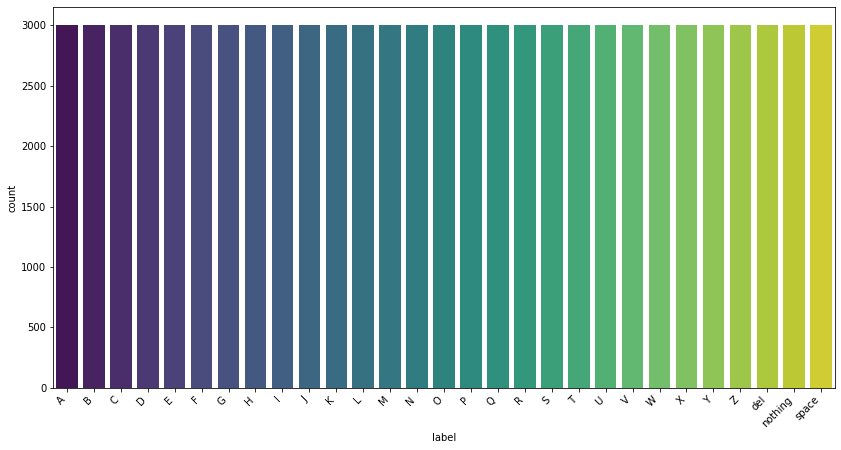

In [10]:
plt.figure(figsize = (14, 7))

class_dist = sns.countplot(
    data= df_data,
    x='label',
    palette='viridis'
)

class_dist.set_xticklabels(class_dist.get_xticklabels(), rotation=45, horizontalalignment='right')

None

In [11]:
#ensure files are read correctly
for files in df_data['img_path'][:5].tolist():
    print(files)

/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/A/A528.jpg
/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/A/A529.jpg
/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/A/A53.jpg
/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/A/A530.jpg
/content/gdrive/MyDrive/kaggle/smallsign/asl_alphabet_train/asl_alphabet_train/A/A531.jpg


In [12]:
data = pd.read_csv('train.csv')

images = []

size_dim = (96,96) # Maximum size for ram avalible

images = file_from_df(data, size_dim)

labels = data['label'].tolist()

LE = LabelEncoder()
labels = LE.fit_transform(labels)

#set up data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1
)

100
(200, 200, 3)
200
(200, 200, 3)
300
(200, 200, 3)
400
(200, 200, 3)
500
(200, 200, 3)
600
(200, 200, 3)
700
(200, 200, 3)
800
(200, 200, 3)
900
(200, 200, 3)
1000
(200, 200, 3)
1100
(200, 200, 3)
1200
(200, 200, 3)
1300
(200, 200, 3)
1400
(200, 200, 3)
1500
(200, 200, 3)
1600
(200, 200, 3)
1700
(200, 200, 3)
1800
(200, 200, 3)
1900
(200, 200, 3)
2000
(200, 200, 3)
2100
(200, 200, 3)
2200
(200, 200, 3)
2300
(200, 200, 3)
2400
(200, 200, 3)
2500
(200, 200, 3)
2600
(200, 200, 3)
2700
(200, 200, 3)
2800
(200, 200, 3)
2900
(200, 200, 3)
3000
(200, 200, 3)
3100
(200, 200, 3)
3200
(200, 200, 3)
3300
(200, 200, 3)
3400
(200, 200, 3)
3500
(200, 200, 3)
3600
(200, 200, 3)
3700
(200, 200, 3)
3800
(200, 200, 3)
3900
(200, 200, 3)
4000
(200, 200, 3)
4100
(200, 200, 3)
4200
(200, 200, 3)
4300
(200, 200, 3)
4400
(200, 200, 3)
4500
(200, 200, 3)
4600
(200, 200, 3)
4700
(200, 200, 3)
4800
(200, 200, 3)
4900
(200, 200, 3)
5000
(200, 200, 3)
5100
(200, 200, 3)
5200
(200, 200, 3)
5300
(200, 200, 3)
54

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

y_train = to_categorical(y_train)
y_test_check = y_test.copy()
y_test = to_categorical(y_test)

In [25]:
base_model = DenseNet201(weights="imagenet",
                        include_top=False,
                        input_shape=(96, 96, 3),
                        pooling = 'avg')

# the base model
head_model = base_model.output

head_model = Flatten(name="flatten")(head_model)

head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.35)(head_model)

head_model = Dense(29, activation="softmax")(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers: 
    layer.trainable = False

# for layer in base_model.layers[0:-12]:
#     layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 102, 102, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [26]:
model_path = '/content/gdrive/MyDrive/Models'
log_path = '/content/gdrive/MyDrive/Model_log' 
model_name_mn = 'DenseNet.weights.best.{epoch:03d}-{val_accuracy:.4f}.hdf5'
tb_path = '/content/gdrive/MyDrive/TB_logs'

In [27]:
callbacks = [
    ModelCheckpoint(
        filepath = os.path.join(model_path, model_name_mn),
        monitor = 'val_loss', 
        save_best_only = True, 
        mode = 'max'
        ),

    CSVLogger(
        filename=os.path.join(log_path, 'log_mn.csv'), 
        separator = ',', 
        append = True
        ),

    EarlyStopping(
        monitor = 'val_loss',
        patience = 5
        ),

    TensorBoard(
        log_dir = tb_path,
        histogram_freq = 10,
        write_graph = True,
        write_images = True,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 0,
        embeddings_freq = 0,
        embeddings_metadata = None
        )
    ]

In [28]:
K.set_value(model.optimizer.lr, 3e-4)

In [29]:
model.fit(
        datagen.flow(X_train, y_train),
        validation_data = (X_test, y_test),
        epochs = 200,
        batch_size = 32,
        callbacks = callbacks
        )

Epoch 1/200
2176/2176 [==============================] - 194s 85ms/step - loss: 1.4648 - accuracy: 0.5656 - val_loss: 0.5362 - val_accuracy: 0.8420
Epoch 2/200
2176/2176 [==============================] - 180s 83ms/step - loss: 0.7276 - accuracy: 0.7680 - val_loss: 0.4026 - val_accuracy: 0.8712
Epoch 3/200
2176/2176 [==============================] - 184s 85ms/step - loss: 0.5870 - accuracy: 0.8111 - val_loss: 0.3388 - val_accuracy: 0.8918
Epoch 4/200
2176/2176 [==============================] - 184s 85ms/step - loss: 0.5150 - accuracy: 0.8321 - val_loss: 0.2944 - val_accuracy: 0.9033
Epoch 5/200
2176/2176 [==============================] - 178s 82ms/step - loss: 0.4710 - accuracy: 0.8445 - val_loss: 0.2787 - val_accuracy: 0.9063
Epoch 6/200
2176/2176 [==============================] - 187s 86ms/step - loss: 0.4411 - accuracy: 0.8556 - val_loss: 0.2586 - val_accuracy: 0.9135
Epoch 7/200
2176/2176 [==============================] - 182s 84ms/step - loss: 0.4142 - accuracy: 0.8635 - val_

In [34]:
for layer in base_model.layers[0:-21]:
    layer.trainable = True

In [35]:
K.set_value(model.optimizer.lr, 5e-5)

In [36]:
model.fit(
        datagen.flow(X_train, y_train),
        validation_data = (X_test, y_test),
        epochs = 200,
        batch_size = 32,
        callbacks = callbacks
        )

Epoch 1/200
2176/2176 [==============================] - 184s 85ms/step - loss: 0.2523 - accuracy: 0.9164 - val_loss: 0.1482 - val_accuracy: 0.9485
Epoch 2/200
2176/2176 [==============================] - 184s 84ms/step - loss: 0.2427 - accuracy: 0.9177 - val_loss: 0.1476 - val_accuracy: 0.9481
Epoch 3/200
2176/2176 [==============================] - 184s 84ms/step - loss: 0.2429 - accuracy: 0.9187 - val_loss: 0.1428 - val_accuracy: 0.9497
Epoch 4/200
2176/2176 [==============================] - 186s 85ms/step - loss: 0.2405 - accuracy: 0.9190 - val_loss: 0.1464 - val_accuracy: 0.9488
Epoch 5/200
2176/2176 [==============================] - 187s 86ms/step - loss: 0.2367 - accuracy: 0.9208 - val_loss: 0.1405 - val_accuracy: 0.9513
Epoch 6/200
2176/2176 [==============================] - 187s 86ms/step - loss: 0.2407 - accuracy: 0.9190 - val_loss: 0.1418 - val_accuracy: 0.9503
Epoch 7/200
2176/2176 [==============================] - 187s 86ms/step - loss: 0.2365 - accuracy: 0.9218 - val_

In [37]:
for layer in base_model.layers[0:-35]:
    layer.trainable = True

In [40]:
K.set_value(model.optimizer.lr, 1e-5)

In [41]:
model.fit(
        datagen.flow(X_train, y_train),
        validation_data = (X_test, y_test),
        epochs = 200,
        batch_size = 32,
        callbacks = callbacks
        )

Epoch 1/200
2176/2176 [==============================] - 190s 87ms/step - loss: 0.2241 - accuracy: 0.9247 - val_loss: 0.1293 - val_accuracy: 0.9546
Epoch 2/200
2176/2176 [==============================] - 188s 86ms/step - loss: 0.2203 - accuracy: 0.9254 - val_loss: 0.1293 - val_accuracy: 0.9538
Epoch 3/200
2176/2176 [==============================] - 192s 88ms/step - loss: 0.2173 - accuracy: 0.9264 - val_loss: 0.1288 - val_accuracy: 0.9547
Epoch 4/200
2176/2176 [==============================] - 191s 88ms/step - loss: 0.2201 - accuracy: 0.9273 - val_loss: 0.1300 - val_accuracy: 0.9539
Epoch 5/200
2176/2176 [==============================] - 190s 87ms/step - loss: 0.2213 - accuracy: 0.9253 - val_loss: 0.1278 - val_accuracy: 0.9550
Epoch 6/200
2176/2176 [==============================] - 192s 88ms/step - loss: 0.2144 - accuracy: 0.9271 - val_loss: 0.1281 - val_accuracy: 0.9545
Epoch 7/200
2176/2176 [==============================] - 192s 88ms/step - loss: 0.2179 - accuracy: 0.9258 - val_

In [42]:
predictions = np.argmax(model.predict(X_test), axis=-1)

In [43]:
predictions = predictions.tolist()

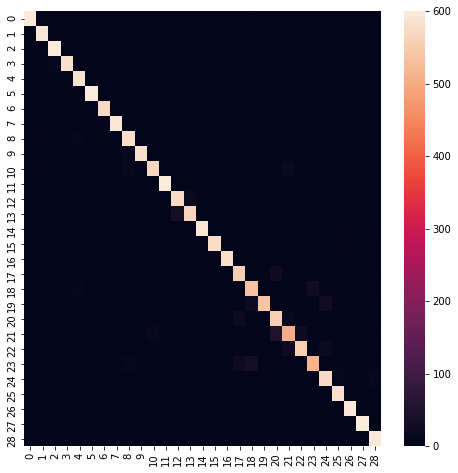

In [44]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test_check, predictions))
plt.show()

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test_check,predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       600
           1       0.97      0.99      0.98       600
           2       0.99      1.00      0.99       600
           3       0.99      0.97      0.98       600
           4       0.95      0.97      0.96       600
           5       1.00      1.00      1.00       600
           6       0.98      0.95      0.97       601
           7       0.99      0.98      0.99       601
           8       0.92      0.96      0.94       600
           9       0.98      0.97      0.97       600
          10       0.97      0.95      0.96       601
          11       0.97      1.00      0.98       600
          12       0.95      0.96      0.95       600
          13       0.97      0.94      0.95       600
          14       0.99      0.98      0.98       601
          15       0.97      0.96      0.97       600
          16       0.99      0.96      0.98       600
          17       0.92    

classes 8 17 and 20 are difficult to predict. These correspond to I, R, and U. 



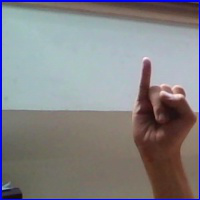

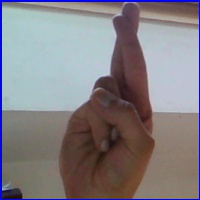

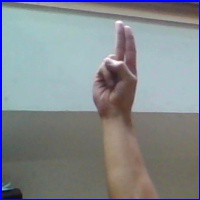

In [7]:
from PIL import Image

I = df_data[df_data.label == 'I']
R = df_data[df_data.label == 'R']
U = df_data[df_data.label == 'U']

I_img = Image.open(I.img_path.iloc[0])
R_img = Image.open(R.img_path.iloc[0])
U_img = Image.open(U.img_path.iloc[0])

display(I_img)
display(R_img)
display(U_img)

In [ ]:
model_custom_json = model.to_json()
with open("model_mn.json", "w") as json_file_custom:
    json_file_custom.write(model_custom_json)
model.save_weights("model_mn.h5")

In [ ]:
from google.colab import files

files.download("model_mn.json")
files.download("model_mn.h5")

In [ ]:
le_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
le_name_mapping

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

In [ ]:
df = pd.DataFrame(le_name_mapping.items(), columns=['label', 'argmax_val'])

In [ ]:
df.to_csv('results_dict.csv',index=False)